<a href="https://colab.research.google.com/github/laliali20/Capstone/blob/main/DSICapstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The goal of the project is to build a revenue optimization system which uses an analysis of historical trends to determine optimal pricing for products in a company's portfolio. The case in the project is for a self storage facility company. The demand data, which is number of move ins as well as move outs is sourced from simulating on Rockwell arena software. The pricing history is sourced from Prorize LLC owned data scraped by StorTrak. While this contains a history of web rate prices, it does not contain a history of rentals or actual transactions and promotions. Moreover, it also contains only a snapshot of the current active units available in one facility. Due to this there was a need to simulate demand trends in order to have the appropriate inputs needed for the goal of the project. 

# Data Import and Processing

In [1]:
import pandas as pd
import statsmodels.formula.api as smf
import math
import matplotlib.pyplot as plt
import sqlalchemy
import urllib
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import math
import sqlite3

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Processing

In [2]:
# import relevant data
df1 = pd.read_excel('/content/occupancysummary.xlsx')
df2 = pd.read_excel('/content/renthistory.xlsx', sheet_name='FinProcessed')
df3 = pd.read_excel('/content/renthistory.xlsx', sheet_name='UnitMaster')
df4 = pd.read_excel('/content/renthistory.xlsx', sheet_name='UnitGroups')
df1.head()

,SSDate,"MoveIns, 1BR","MoveIns, 2BR","MoveIns, STD","MoveIns, Site","MoveOuts, 1BR","MoveOuts, 2BR","MoveOuts, STD","MoveOuts, Site","Renewals, 1BR",...,MICoeff_1BR,MICoeff_2BR,MICoeff_STD,MOCoeff_1BR,MOCoeff_2BR,MOCoeff_STD,Cutoff,OccPct 1,OccPct 2,OccPct 3
0,2011-12-01,22.0,5.0,40.0,67.0,14.0,1.0,18.0,33.0,11.0,...,0.729494,0.690909,0.897549,0.948307,0.255892,0.814286,0,0.8975,0.95,0.930000
1,2012-01-01,21.0,4.0,37.0,62.0,15.0,2.0,12.0,29.0,5.0,...,0.696335,0.552727,0.830233,1.016043,0.511785,0.542857,0,0.9000,0.95,0.936667
2,2012-02-01,28.0,1.0,37.0,66.0,11.0,5.0,8.0,24.0,16.0,...,0.928447,0.138182,0.830233,0.745098,1.279461,0.361905,0,0.9025,0.90,0.945000
3,2012-03-01,35.0,7.0,37.0,79.0,24.0,6.0,23.0,53.0,21.0,...,1.160558,0.967273,0.830233,1.625668,1.535354,1.040476,0,0.8775,0.87,0.933333
4,2012-04-01,29.0,10.0,44.0,83.0,16.0,8.0,22.0,46.0,14.0,...,0.961606,1.381818,0.987304,1.083779,2.047138,0.995238,0,0.8750,0.84,0.930000


In [3]:
df2.head()

,LeaseNo,StartDate,EndDate,UnitPlan,Month1,Month2,Month3,Month4,Month5,Month6,...,Month100,Month101,Month102,Month103,Month104,Month105,Month106,Month107,Month108,Month109
0,12435,2010-02-01,2012-02-01,product group - 3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12436,2009-10-01,2012-10-01,product group - 3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12437,2011-01-01,2012-01-01,product group - 3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12438,2010-05-01,2012-05-01,product group - 3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12439,2011-02-01,2012-02-01,product group - 3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# rename and process the relevant columns
# this is necessary due the output format in the simulation

min_sartdate = df1['SSDate'].min()
rentalHistory = df2[df2['StartDate'] >= min_sartdate]
prod_group_1 = df1[['SSDate', 'MoveIns, 1BR', 'MoveOuts, 1BR', 'Renewals, 1BR', 'Occupancy, 1BR', 'MICoeff_1BR','MOCoeff_1BR', 'Cutoff']]
prod_group_2 = df1[['SSDate', 'MoveIns, 2BR', 'MoveOuts, 2BR', 'Renewals, 2BR', 'Occupancy, 2BR', 'MICoeff_2BR', 'MOCoeff_2BR', 'Cutoff']]
prod_group_3 = df1[['SSDate', 'MoveIns, STD', 'MoveOuts, STD', 'Renewals, STD', 'Occupancy, STD', 'MICoeff_STD', 'MOCoeff_STD', 'Cutoff']]
prod_group_3.head()

prod_group_3['OptProductKey'] = 'product group - 3'
prod_group_2['OptProductKey'] = 'product group - 2'
prod_group_1['OptProductKey'] = 'product group - 1'

prod_group_1.rename(columns={"MoveIns, 1BR": "UncDemand", "MoveOuts, 1BR": "MoveOuts","Renewals, 1BR": "Renewals", "Occupancy, 1BR": "Occupied", "MICoeff_1BR": "MICoeff", "MOCoeff_1BR": "MOCoeff", "OccPct 1":"Occupancy"},inplace=True)
prod_group_2.rename(columns={"MoveIns, 2BR": "UncDemand", "MoveOuts, 2BR": "MoveOuts","Renewals, 2BR": "Renewals", "Occupancy, 2BR": "Occupied", "MICoeff_2BR": "MICoeff", "MOCoeff_2BR": "MOCoeff", "OccPct 2":"Occupancy"},inplace=True)
prod_group_3.rename(columns={"MoveIns, STD": "UncDemand", "MoveOuts, STD": "MoveOuts","Renewals, STD": "Renewals", "Occupancy, STD": "Occupied", "MICoeff_STD": "MICoeff", "MOCoeff_STD": "MOCoeff", "OccPct 3":"Occupancy"},inplace=True)
prod_group_3.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,SSDate,UncDemand,MoveOuts,Renewals,Occupied,MICoeff,MOCoeff,Cutoff,OptProductKey
0,2011-12-01,40.0,18.0,15.0,558.0,0.897549,0.814286,0,product group - 3
1,2012-01-01,37.0,12.0,21.0,562.0,0.830233,0.542857,0,product group - 3
2,2012-02-01,37.0,8.0,24.0,567.0,0.830233,0.361905,0,product group - 3
3,2012-03-01,37.0,23.0,21.0,560.0,0.830233,1.040476,0,product group - 3
4,2012-04-01,44.0,22.0,24.0,558.0,0.987304,0.995238,0,product group - 3


In [5]:
prod_group_2.head()

,SSDate,UncDemand,MoveOuts,Renewals,Occupied,MICoeff,MOCoeff,Cutoff,OptProductKey
0,2011-12-01,5.0,1.0,3.0,95.0,0.690909,0.255892,0,product group - 2
1,2012-01-01,4.0,2.0,2.0,95.0,0.552727,0.511785,0,product group - 2
2,2012-02-01,1.0,5.0,1.0,90.0,0.138182,1.279461,0,product group - 2
3,2012-03-01,7.0,6.0,4.0,87.0,0.967273,1.535354,0,product group - 2
4,2012-04-01,10.0,8.0,5.0,84.0,1.381818,2.047138,0,product group - 2


In [6]:
prod_group_1.head()

,SSDate,UncDemand,MoveOuts,Renewals,Occupied,MICoeff,MOCoeff,Cutoff,OptProductKey
0,2011-12-01,22.0,14.0,11.0,359.0,0.729494,0.948307,0,product group - 1
1,2012-01-01,21.0,15.0,5.0,360.0,0.696335,1.016043,0,product group - 1
2,2012-02-01,28.0,11.0,16.0,361.0,0.928447,0.745098,0,product group - 1
3,2012-03-01,35.0,24.0,21.0,351.0,1.160558,1.625668,0,product group - 1
4,2012-04-01,29.0,16.0,14.0,350.0,0.961606,1.083779,0,product group - 1


In [7]:
pd.get_option('display.max_columns')
product_history = [prod_group_1, prod_group_2, prod_group_3]
n = 0
frames = []
inputdata = pd.concat(product_history) 
product_list = inputdata['OptProductKey'].unique()
product_list

array(['product group - 1', 'product group - 2', 'product group - 3'],
      dtype=object)

In [8]:
inputdata.tail()

,SSDate,UncDemand,MoveOuts,Renewals,Occupied,MICoeff,MOCoeff,Cutoff,OptProductKey
72,2017-12-01,41.0,21.0,20.0,554.0,0.919988,0.950000,0,product group - 3
73,2018-01-01,29.0,25.0,14.0,544.0,0.650723,1.130952,0,product group - 3
74,2018-02-01,32.0,20.0,15.0,541.0,0.718040,0.904762,0,product group - 3
75,2018-03-01,46.0,25.0,22.0,540.0,1.032182,1.130952,0,product group - 3
76,2018-04-01,NaN,NaN,NaN,NaN,1.279008,0.859524,0,product group - 3


In [9]:
unitMaster = df3.groupby(['UnitType', 'Sqft']).agg('count')

# fig = plt.figure()
# ax = fig.add_axes([0,0,1,1])
# ax.bar()
# plt.show()

# Forecasting and Model Fitting

In [10]:
# forecast 
def generate_forecast(input_data, alpha, yt_date):
  # forecast 
  frames = []
  # def generate_forecast(input_data, alpha, yt_date):
  # alpha = 0.6
  # yt_date_df = inputdata[inputdata['UncDemand'].notna()]
  # yt_date = yt_date_df['SSDate'].max()
  product_list = inputdata['OptProductKey'].unique()
  for productkey in product_list:
      product = inputdata[(inputdata['OptProductKey']==productkey)].sort_values('SSDate')
      mi_base = product['UncDemand'].tolist()
      deseas_mi_fcast = []
      dates = product['SSDate'].tolist()
      mi_seasonality_coeff = product['MICoeff'].tolist()
      mi_fcast = []
      net_mi_fcast = []
      mo_base = product['MoveOuts'].tolist()
      deseas_mo_fcast = []
      mo_seasonality_coeff = product['MOCoeff'].tolist()
      mo_fcast = []
      
      # occupied = product['Occupancy'].tolist()
      # occupied_fcast = []
      
      # avg_size = product['AvgSize'].tolist()
      # avg_occ_size = product['AvgOccupiedSize'].tolist()
      # total_size = product['TotalSqft'].tolist()
      # tot_sqft = []
      
      # print(productkey)
      
      for i in range(len(mi_seasonality_coeff)):
          if i == 0:
              deseas_mi_fcast.append(mi_base[i]/mi_seasonality_coeff[i])
              mi_fcast.append(deseas_mi_fcast[i] * mi_seasonality_coeff[i])
              deseas_mo_fcast.append(mo_base[i]/mo_seasonality_coeff[i])
              mo_fcast.append(deseas_mo_fcast[i] * mo_seasonality_coeff[i])
              net_mi_fcast.append(mi_fcast[i] - mo_fcast[i])
              # occupied_fcast.append(min((occupied[i] + net_mi_fcast[i]) * avg_occ_size[i], total_size[i]))
              # tot_sqft.append(total_size[i])
          elif i > 0 and dates[i] < yt_date:
              deseas_mi_fcast.append(alpha * (mi_base[i]/mi_seasonality_coeff[i]) + (1 - alpha) * deseas_mi_fcast[i - 1])
              mi_fcast.append(deseas_mi_fcast[i] * mi_seasonality_coeff[i])
              deseas_mo_fcast.append(alpha * (mo_base[i]/mo_seasonality_coeff[i]) + (1 - alpha) * deseas_mo_fcast[i - 1])
              mo_fcast.append(deseas_mo_fcast[i] * mo_seasonality_coeff[i])
              net_mi_fcast.append(mi_fcast[i] - mo_fcast[i])
              # occupied_fcast.append(min((occupied[i] + net_mi_fcast[i]) * avg_occ_size[i], total_size[i]))
              # tot_sqft.append(total_size[i])
          elif dates[i] == yt_date:
              deseas_mi_fcast.append(alpha * (mi_base[i - 1]/mi_seasonality_coeff[i - 1]) + (1 - alpha) * deseas_mi_fcast[i - 1])
              mi_fcast.append(deseas_mi_fcast[i] * mi_seasonality_coeff[i])
              deseas_mo_fcast.append(alpha * (mo_base[i - 1]/mo_seasonality_coeff[i - 1]) + (1 - alpha) * deseas_mo_fcast[i - 1])
              mo_fcast.append(deseas_mo_fcast[i] * mo_seasonality_coeff[i])
              net_mi_fcast.append(mi_fcast[i] - mo_fcast[i])
              # occupied_fcast.append(min((net_mi_fcast[i] + net_mi_fcast[dates.index(yt_date) - 1] + occupied[dates.index(yt_date) - 1]) * avg_occ_size[dates.index(yt_date) - 1], total_size[dates.index(yt_date) - 1]))
              # tot_sqft.append(total_size[dates.index(yt_date) - 1])
          elif dates[i] > yt_date:
              deseas_mi_fcast.append(deseas_mi_fcast[dates.index(yt_date)])
              mi_fcast.append(deseas_mi_fcast[dates.index(yt_date)] * mi_seasonality_coeff[i])
              deseas_mo_fcast.append(deseas_mo_fcast[dates.index(yt_date)])
              mo_fcast.append(deseas_mo_fcast[dates.index(yt_date)] * mo_seasonality_coeff[i])
              net_mi_fcast.append(mi_fcast[i] - mo_fcast[i])
              # occupied_fcast.append(min((sum(net_mi_fcast[dates.index(yt_date):i + 1]) + net_mi_fcast[dates.index(yt_date) - 1] + occupied[dates.index(yt_date) - 1]) * avg_size[dates.index(yt_date) - 1], total_size[dates.index(yt_date) - 1]))
              # tot_sqft.append(total_size[dates.index(yt_date) - 1])
          
          # p

      product['MIFcast'] = mi_fcast
      product['MOFcast'] = mo_fcast
      product['NetMIFcast'] = net_mi_fcast

      # print('product {}'.format(productkey))
      frames.append(product)

  products  = pd.concat(frames)

  return products 

In [11]:

# store_level = products.groupby(['MasterSiteKey', 'Name', 'SSDate'], as_index=False).agg({'OccSqft': 'sum','Sqft_occupied_fcast':'sum','TotSqft':'sum', 'NetAmount': 'sum'})
# store_level['ActualOccupancy'] = store_level['OccSqft']/store_level['TotSqft']
# store_level['ForecastOccupancy'] = store_level['Sqft_occupied_fcast']/store_level['TotSqft']
# stores  = store_level['MasterSiteKey'].unique()
# store_level = store_level.merge(trend, on=['MasterSiteKey','SSDate'], how='left')

# store_level.loc[store_level['SSDate'] >= yt_date, ['NetAmount']] = np.nan
# store_level.loc[store_level['SSDate'] >= yt_date, ['OccSqft']] = np.nan 
# store_level.loc[store_level['SSDate'] >= yt_date, ['ActualOccupancy']] = np.nan

# # # Assmuption for 0 occupied sqft

# store_level = store_level.loc[store_level['OccSqft'] != 0]
# def log_col(row_val):
#     return math.log(row_val)

# # products[products['OptProductKey']==25].tail(15)

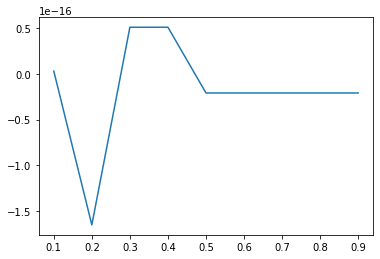

In [12]:
# eventual cutoff
def forecast_performance(prod_group_1, input_data, alpha):
  
  # alphas = 0.6
  yt_date_df = prod_group_1['SSDate'].max()
  holdout_cutoff_df = prod_group_1.loc[prod_group_1['Cutoff'] == 1, ['SSDate']]
  holdout_cutoff = holdout_cutoff_df['SSDate'].max()

  fcast_test = inputdata[inputdata['SSDate'] <= holdout_cutoff]
  fcast_res = generate_forecast(fcast_test, alpha, holdout_cutoff)
  fcast_res['AbsPE'] = (fcast_res['UncDemand'] - fcast_res['MIFcast'])/fcast_res['UncDemand']
  holdout = fcast_res[fcast_res['SSDate'] > holdout_cutoff ]
  holdout_fin = holdout[holdout['UncDemand'].notna()]
  return holdout_fin['AbsPE'].mean()

alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
mapes = []
for alpha_val in alphas:
  mapes.append(forecast_performance(prod_group_1, inputdata, alpha_val))

plt.plot(alphas, mapes)
plt.show()
# mapes

In [13]:
yt_date_df = inputdata[inputdata['UncDemand'].notna()]
yt_date = yt_date_df['SSDate'].max()
products = generate_forecast(inputdata, 0.2, yt_date)

# Ref Price Calculation

In [14]:
# # '10413 - Simply - Raytown - State Route 350' 
# frames_stores = []  
# # adj = pd.read_excel('C:/Users/lali/OneDrive - Prorize LLC/Desktop/adjustments1.xlsx', 'adjsheet')  

# for store in stores:
#     store_data = store_level[store_level['MasterSiteKey'] == store]
#     reg_input_df = store_data[store_data['SSDate'] < yt_date]
#     # reg_input_df
#     reg_input_df['lnrev'] = reg_input_df.apply(lambda x: log_col(x['NetAmount']), axis=1)
#     reg_input_df['lnocc'] = reg_input_df.apply(lambda x: log_col(x['OccSqft']), axis=1)

#     y = reg_input_df['lnrev']
#     x = reg_input_df[['lnocc','Trend']]
#     x = sm.add_constant(x, prepend=True)
#     reg = sm.OLS(y, x).fit()
#     reg_result = pd.DataFrame(columns=reg.params.index, data=[[reg.params[0], reg.params[1], reg.params[2]]])
#     reg_result['MasterSiteKey'] = store
#     reg_result['rsquared'] = reg.rsquared
#     bias = store_data.loc[(store_data['SSDate'] >= y_lower_cutoff) & (store_data['SSDate'] <= y_upper_cutoff), 'ActualOccupancy'].mean()/store_data.loc[(store_data['SSDate'] >= y_lower_cutoff) & (store_data['SSDate'] <= y_upper_cutoff), 'ForecastOccupancy'].mean()
#     bias_df = pd.DataFrame(columns=['MasterSiteKey','bias'], data=[[store,bias]])
#     temp_yt_trend = store_data.groupby('MasterSiteKey', as_index=False).agg({'Trend': max})
#     temp_ytcutoff_trend = store_data[store_data['SSDate'] == y_upper_cutoff].groupby('MasterSiteKey', as_index=False).agg({'Trend': max})
#     temp_yt_trend = temp_yt_trend.merge(temp_ytcutoff_trend, on=['MasterSiteKey'], how='left')
#     temp_yt_trend['Diff'] = temp_yt_trend['Trend_x'] - temp_yt_trend['Trend_y']
#     temp_yt_df = temp_yt_trend[['MasterSiteKey','Trend_y','Diff']]
#     temp_yt_df.rename(columns={"Trend_y":"Yt_obs"},inplace=True)
#     store_data = store_data.merge(temp_yt_df, on=['MasterSiteKey'], how='left')
#     store_data = store_data.merge(reg_result, on=['MasterSiteKey'], how='left')
#     # store_data = store_data.merge(store_adj, on=['Name'], how='left')
#     store_data = store_data.merge(bias_df, on=['MasterSiteKey'], how='left')
#     frames_stores.append(store_data)
    
# store_reg  = pd.concat(frames_stores)
# store_reg

In [15]:
# mi component
monthly_mi = rentalHistory[['UnitPlan', 'StartDate', 'Month108', 'Month109']]
mi_component_df = monthly_mi[monthly_mi['StartDate'] >= '2018-02-01']
mi_df = mi_component_df.groupby('UnitPlan', as_index = False).mean()
frames = []

for prod in product_list:
  temp_df = mi_df[mi_df['UnitPlan'] == prod]
  mi_avg = (temp_df['Month108'] + temp_df['Month109'])/2
  frames.append(pd.DataFrame({'UnitGroup': prod, 'mi_avg': mi_avg}))
mi_components = pd.concat(frames)
mi_components

,UnitGroup,mi_avg
0,product group - 1,2029.625367
1,product group - 2,2044.647059
2,product group - 3,1732.231571


In [16]:
# occupied component
monthly_occ = rentalHistory[rentalHistory['EndDate'].isna()]
occ_component_df = monthly_occ[['UnitPlan', 'Month98', 'Month99', 'Month100', 'Month101', 'Month102', 'Month103', 'Month104', 'Month105', 'Month106', 'Month107', 'Month108', 'Month109']]


In [17]:
prod_level_occ = occ_component_df.groupby('UnitPlan', as_index=False).mean()
unitgroup_occ = []
occ_avg = []
for prod in product_list:
  temp_df = prod_level_occ[prod_level_occ['UnitPlan'] == prod]
  occ_avg = (temp_df['Month98'] + temp_df['Month99'] + temp_df['Month100'] + temp_df['Month101'] + temp_df['Month102'] + temp_df['Month103'] + temp_df['Month104'] + temp_df['Month105'] + temp_df['Month106'] + temp_df['Month107'] + temp_df['Month108'] + temp_df['Month109'])/12
  unitgroup_occ.append(pd.DataFrame({'UnitGroup': prod, 'occ_avg': occ_avg}))

occ_components = pd.concat(unitgroup_occ)


In [18]:
ref_price_components = mi_components.merge(occ_components, on = ['UnitGroup'], how = 'left')
ref_price_components['ref_price'] = 0.8 * ref_price_components['mi_avg'] + 0.2 * ref_price_components['occ_avg']
ref_price_components

,UnitGroup,mi_avg,occ_avg,ref_price
0,product group - 1,2029.625367,2167.991829,2057.298659
1,product group - 2,2044.647059,2123.716797,2060.461007
2,product group - 3,1732.231571,1723.406241,1730.466505


# Price Generation

In [19]:
fcast_values = products[products['UncDemand'].isna()]
fcast_values.rename(columns={'OptProductKey': 'UnitGroup'}, inplace=True)
optimization_input = ref_price_components.merge(fcast_values, on = ['UnitGroup'], how='left')
fcast_values

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,SSDate,UncDemand,MoveOuts,Renewals,Occupied,MICoeff,MOCoeff,Cutoff,UnitGroup,MIFcast,MOFcast,NetMIFcast
76,2018-04-01,NaN,NaN,NaN,NaN,0.762653,0.745098,0,product group - 1,23.0,11.000000,12.000000
76,2018-04-01,NaN,NaN,NaN,NaN,1.243636,1.535354,0,product group - 2,9.0,5.999999,3.000001
76,2018-04-01,NaN,NaN,NaN,NaN,1.279008,0.859524,0,product group - 3,57.0,19.000000,38.000000


In [20]:
avg_demand = products[products['SSDate']>='2017-03-01'].groupby(['OptProductKey']).agg({'UncDemand':'mean'}, as_index=False) # , 'UncDemand':'std'})
demand_std = products[products['SSDate']>='2017-03-01'].groupby(['OptProductKey']).agg({'UncDemand':'std'}, as_index=False) # , 'UncDemand':'std'})
avg_demand.reset_index( inplace=True)
demand_std.reset_index( inplace=True)
demand_ref_points = avg_demand.merge(demand_std, on = ['OptProductKey'], how='left')
demand_ref_points.rename({'UncDemand_x':'avg_mi', 'UncDemand_y':'std_mi'}, inplace=True)
demand_ref_points['UpperBound'] = demand_ref_points['UncDemand_x'] + demand_ref_points['UncDemand_y'] * 1.96
demand_ref_points['LowerBound'] = demand_ref_points['UncDemand_x'] - demand_ref_points['UncDemand_y'] * 1.96
demand_ref_points.rename(columns={'OptProductKey':'UnitGroup'}, inplace=True)

In [21]:
df_opt = optimization_input.merge(demand_ref_points, on = ['UnitGroup'], how = 'left')

In [22]:
optimization_input = df_opt[['UnitGroup', 'SSDate', 'mi_avg', 'occ_avg', 'ref_price', 'MIFcast', 'MOFcast', 'NetMIFcast', 'LowerBound', 'UpperBound']]
optimization_input

,UnitGroup,SSDate,mi_avg,occ_avg,ref_price,MIFcast,MOFcast,NetMIFcast,LowerBound,UpperBound
0,product group - 1,2018-04-01,2029.625367,2167.991829,2057.298659,23.0,11.000000,12.000000,14.802639,44.120438
1,product group - 2,2018-04-01,2044.647059,2123.716797,2060.461007,9.0,5.999999,3.000001,0.265506,14.811417
2,product group - 3,2018-04-01,1732.231571,1723.406241,1730.466505,57.0,19.000000,38.000000,24.046333,66.261359


In [23]:
# no need for further logic enhancement here since all forecast projections are positive
out_frame = []
for unitgroup in product_list:
  opt_input = optimization_input[optimization_input['UnitGroup'] == unitgroup]
  if float(opt_input['NetMIFcast']) > 0:
    if float(opt_input['MIFcast'])/float(opt_input['UpperBound']) >= 0.7:
      opt_input['UnitGroupRec'] = opt_input['ref_price'] * 1.05
    elif float(opt_input['MIFcast'])/float(opt_input['UpperBound']) >= 0.5:
      opt_input['UnitGroupRec'] = opt_input['ref_price'] * 1.02
    else:
      opt_input['UnitGroupRec'] = opt_input['ref_price'] * 1.01
  else:
    opt_input['UnitGroupRec'] = opt_input['ref_price'] * 0.98    
  out_frame.append(opt_input)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [24]:
optimization_output = pd.concat(out_frame)
# optimization_output.to_csv('Optimization_output')


In [25]:
unitNo_recs = optimization_output.merge(df4, on=['UnitGroup'], how='left')
unitNo_recs['UnitNoRecs'] = (1 + unitNo_recs['SqftAdj']) * unitNo_recs['UnitGroupRec']
unitNo_recs['mi_avg'] = (1 + unitNo_recs['SqftAdj']) * unitNo_recs['mi_avg']
unitNo_recs['occ_avg'] = (1 + unitNo_recs['SqftAdj']) * unitNo_recs['occ_avg']

In [26]:
unitNo_recs

,UnitGroup,SSDate,mi_avg,occ_avg,ref_price,MIFcast,MOFcast,NetMIFcast,LowerBound,UpperBound,UnitGroupRec,UnitType,Sqft,UnitName,SqftAdj,Occupied,UnitCount,Occupancy,UnitNoRecs
0,product group - 1,2018-04-01,1449.732405,1548.565592,2057.298659,23.0,11.000000,12.000000,14.802639,44.120438,2098.444632,1BR,750,1BR-750,-0.285714,184,200,0.920,1498.889023
1,product group - 1,2018-04-01,2029.625367,2167.991829,2057.298659,23.0,11.000000,12.000000,14.802639,44.120438,2098.444632,1BR,1050,1BR-1050,0.000000,171,200,0.855,2098.444632
2,product group - 2,2018-04-01,2044.647059,2123.716797,2060.461007,9.0,5.999999,3.000001,0.265506,14.811417,2101.670227,2BR,1250,2BR-1250,0.000000,91,100,0.910,2101.670227
3,product group - 3,2018-04-01,666.242912,662.848554,1730.466505,57.0,19.000000,38.000000,24.046333,66.261359,1816.989830,STD,450,STD-450,-0.615385,279,300,0.930,698.842242
4,product group - 3,2018-04-01,1324.647672,1317.898890,1730.466505,57.0,19.000000,38.000000,24.046333,66.261359,1816.989830,STD,650,STD-650,-0.235294,180,200,0.900,1389.462811
5,product group - 3,2018-04-01,1732.231571,1723.406241,1730.466505,57.0,19.000000,38.000000,24.046333,66.261359,1816.989830,STD,850,STD-850,0.000000,84,100,0.840,1816.989830


# Conclusion
The project utilizes the available data and comes up with a list of recommendations and a summary of key performance indicators that can be shown to a client. The logic used to optimize was simplistic but a more robust approach can be applied with access to appropriate revenue-related data such as transactions. In fact one major limitation due to the unavailability of transactions is that a crucial input, demand elasticity, which is a measure of how much a change in demand can affect the customer decision of whether to keep using the product, is not computable. However, given what has been available, the logic behind the generation of the recommendations have been tuned to make market sense. A dashboard has been manually prepared based on the output csv files on this notebook

In [27]:
# analytics to show
# move ins
# move outs
# renewals
# occupancy
mi_occ_df = inputdata[inputdata['SSDate'] <= yt_date]
mi_occ_df.to_csv('output1.csv')


# unit counts
# unit count distribution
# unitMaster

# table with
# unit count
# occupancy
# current rent
# occupied rent
# reccommendation
# curr vs rec
# occ vs rec
# curr vs occ
unitNo_recs.to_csv('output2.csv')
